In [1]:
import numpy as np
from scipy import constants as c
from scipy import special as sp
from iminuit import Minuit, cost
from argparse import Namespace
import pandas as pd
import os
import matplotlib.pyplot as plt

C:\Users\ricca\AppData\Local\Temp\ipykernel_16880\2767033686.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
KB = c.Boltzmann
hbar = c.Planck

In [3]:
def QT(T,d0, q0, alpha, omega):
    csi = (hbar * omega)/(2*KB*T)
    num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
    den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
    return num/den * (alpha/2) + 1/q0

def kondo(T,d0, q0, alpha, omega, b, T_k):
    csi = (hbar * omega)/(2*KB*T)
    num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
    den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
    return num/den * (alpha/2) + 1/q0 - b*np.log(T/T_k)

def retta(x, m, q):
    return m*x + q

def resonance(x, x0, Q, Q_c, phi0):
    num = np.exp(1j*phi0)
    den = 1 + 2*1j*Q*(x-x0)/x0
    return abs(1 - (Q/Q_c)*(num/den))

def model(x,m,q,x0,Q,Q_c,phi0):
    return retta(x,m,q)*resonance(x,x0,Q,Q_c,phi0)

def FWHM(x,y):
    x = np.array(x)
    y = np.array(y)
    half = max(y) - (max(y)-min(y)) / 2.
    minimums = x[np.where(y < half)]
    if len(minimums)==0: 
        print('Minimum not found!')
        return 0,1
    else:
        return (max(minimums) - min(minimums)),0

def mod(x,y):
    return np.sqrt(x**2 + y**2)
    
def Q_stima(x0,w):
    if (((x0 is None) or (w is None)) or w==0):
        print('Q_stima: None detected!')
        return 0
    else:
        return x0/(2*w)
    
def Sort_Tuple(tup):
 
    # getting length of list of tuples
    lst = len(tup)
    for i in range(0, lst):
        for j in range(0, lst-i-1):
            if (tup[j][1] > tup[j + 1][1]):
                temp = tup[j]
                tup[j] = tup[j + 1]
                tup[j + 1] = temp
    return tup

def plotter(m,new_dfs,t):
       
    for i in range(len(m)):
        figure = plt.figure()
        m[i].params
        plt.scatter(new_dfs[i]['f'], new_dfs[i]['mod'], marker='.', s=0.1, label='data', color='black')
        plt.plot(new_dfs[i]['f'], model(new_dfs[i]['f'], *m[i].values[:]), label='model', color='red')
        plt.fill_between(new_dfs[i]['f'], new_dfs[i]['mod']-new_dfs[i]['mod_err'], new_dfs[i]['mod']+new_dfs[i]['mod_err'], alpha=0.5, color='blue')

        chi2 = m[i].fval
        ndof = m[i].ndof

        title = [
            f"chi2/ndof = {chi2:.1f}/{ndof}={chi2/ndof:.1f}",
        ]

        for par in m[i].parameters:
            title.append(
                f"{par} = {m[i].values[par]:.4f} +/- {m[i].errors[par]:.4f}"
            )
        plt.suptitle('T='+str(t[i])+' K')
        plt.title('Run number'+str(i))
        plt.legend(title="\n".join(title))
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()
    return

In [4]:
folder = 'C:\\Users\\ricca\\Desktop\\MAGISTRALE\\LabIV\\QTLab2324\\IRdetection\\Instruments\\Test_data\\fit_prova\\gap_run12\\'

lista = os.listdir(folder)

dfs,temp = [],[]
count = 0
lista2 = []
for (i,nome) in enumerate(lista):
    var = []
    var.append(i)
    var.append(int(str(nome.split('Q_res')[1].split('.txt')[0])))
    lista2.append(var)
lista2 = Sort_Tuple(lista2)
    
for (i,nome) in lista2:
    if (i % 2 == 0): 
        data = pd.read_csv(folder+'Q_res'+str(nome)+'.txt', sep=",")
        data.columns = ['f','i','q']
        dfs.append(data)
        temp.append(410 - int(i/2)*10)

In [5]:
for df in dfs:
    if type(df) is not int:
        col = np.sqrt(np.array(df.loc[:,'i'])*np.array(df.loc[:,'i']) + np.array(df.loc[:,'q'])*np.array(df.loc[:,'q']))
        col2 = np.ones_like(col)*0.001
        df.insert(3,'mod',col)
        df.insert(4,'mod_err',col2)

In [6]:
par, m, no_minimums = [], [], []
for (i,df) in enumerate(dfs):
    width,err = FWHM(np.array(df['f']),(np.array(df['mod'])))
    if(err==1):
        no_minimums.append(i)      
    stima_x0 = float(np.array(df['f'])[np.where(np.array(df['mod']) == min(np.array(df['mod'])))])
    stima_Q = Q_stima(stima_x0,width)
    stima_m = ((np.array(df['mod']))[0]-(np.array(df['mod']))[-1])/(np.array(df['f'])[0]-np.array(df['f'])[-1])
    stima_q = (np.array(df['mod']))[0] - stima_m * (np.array(df['f']))[0]
    stima_Q_c = 10000
    stima_phi0 = 0.2
    ns = np.array([width,stima_x0,stima_Q,stima_m,stima_q,stima_Q_c,stima_phi0])
    lsq = cost.LeastSquares(np.array(df['f']), np.array(df['mod']), df['mod_err'], model)
    m.append(Minuit(lsq, m=stima_m,q=stima_q,x0=stima_x0,Q=stima_Q,Q_c=stima_Q_c,phi0=stima_phi0))

C:\Users\ricca\AppData\Local\Temp\ipykernel_16880\2275253190.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stima_x0 = float(np.array(df['f'])[np.where(np.array(df['mod']) == min(np.array(df['mod'])))])


In [7]:
m2,new_temp2, new_dfs2 = [], [], []
for i in range(len(m)):
    m[i].migrad(ncall=10000)
    if (m[i].valid==True):
        new_dfs2.append(dfs[i])
        new_temp2.append(temp[i]*1e-3)
        m2.append(m[i])
new_temp2.sort(reverse=True)
    #m[i].limit['stima_x0'] = (stima_x0*(1-0.1),stima_x0*(1+0.1))
    #m[i].Minuit.limit(stima_Q,stima_Q*(1-0.1),stima_Q*(1+0.1))
    #m[i].Minuit.limit(stima_Q_c, stima_Q_c*(1-0.1),stima_Q_c*(1+0.1))
    #m[i].Minuit.limit(stima_phi0,0.1,0.5)

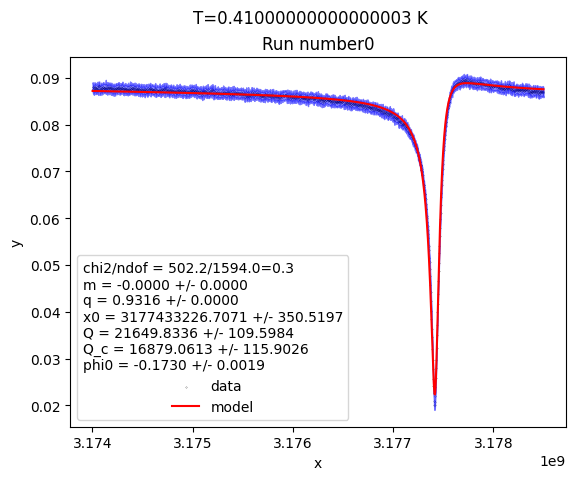

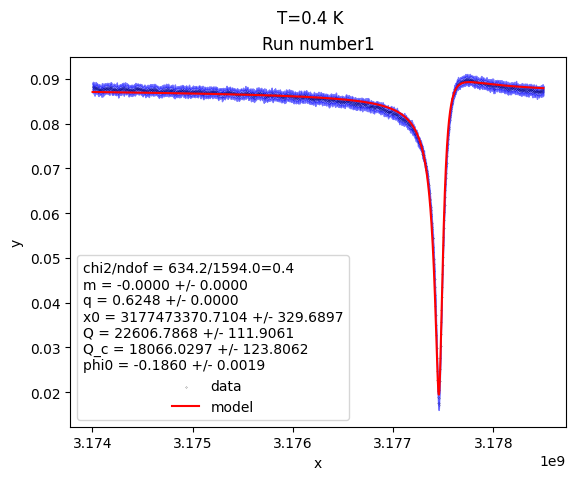

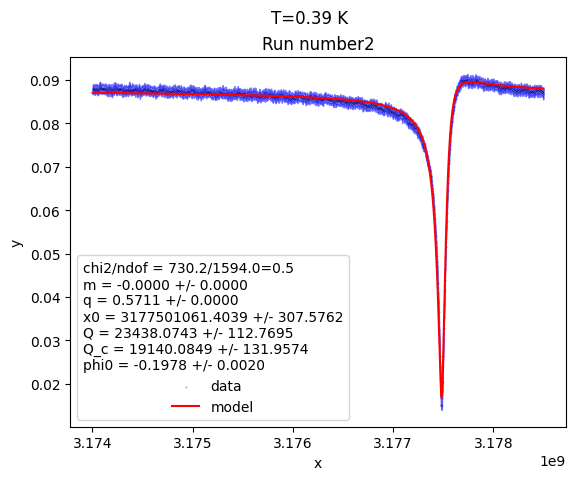

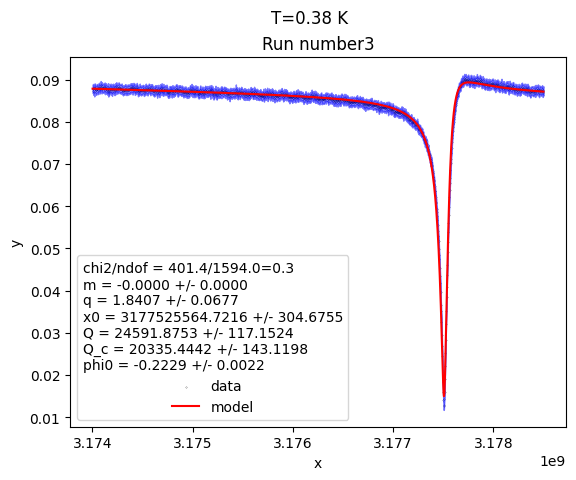

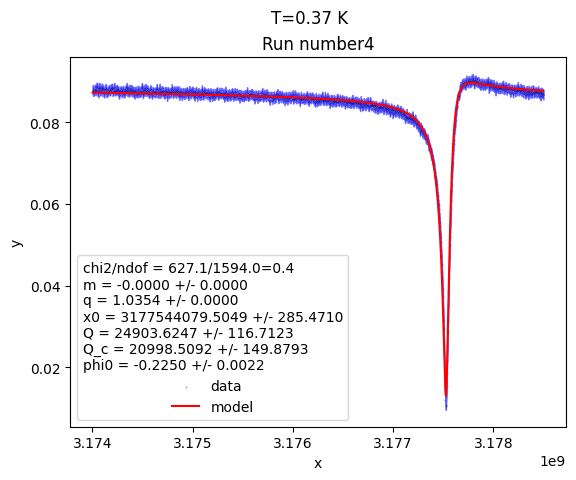

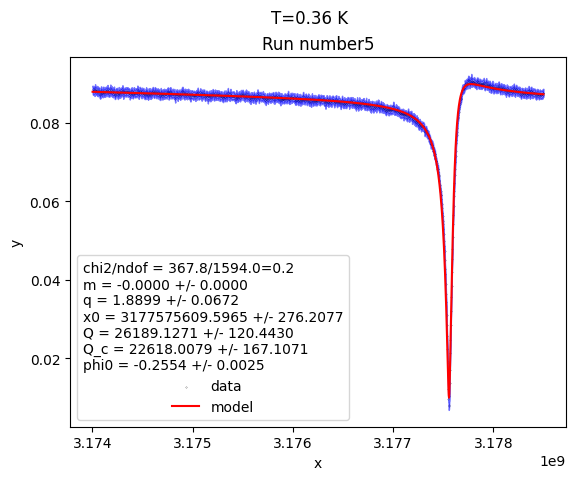

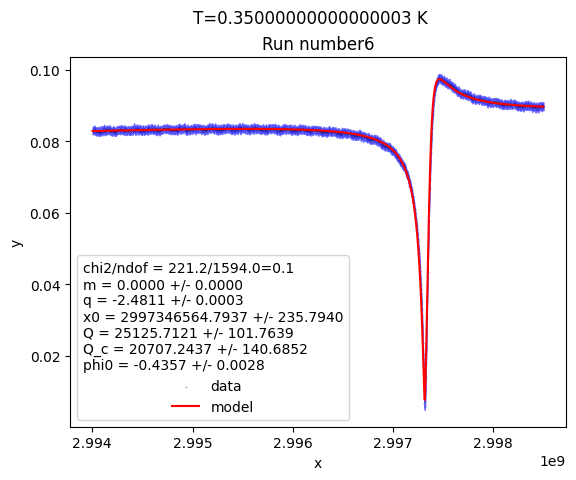

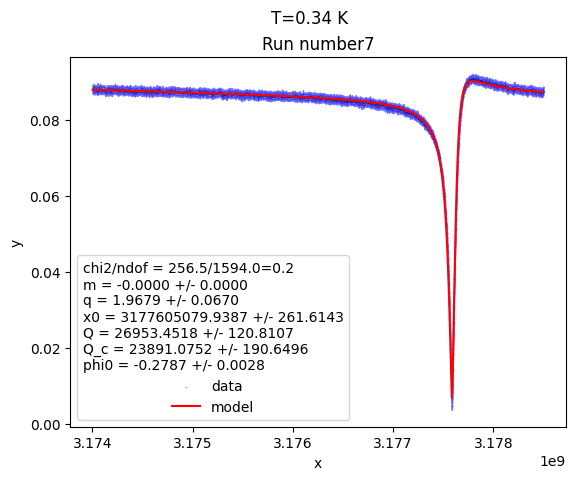

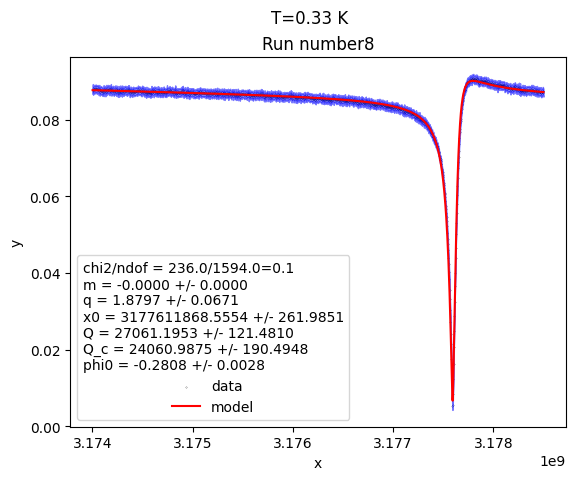

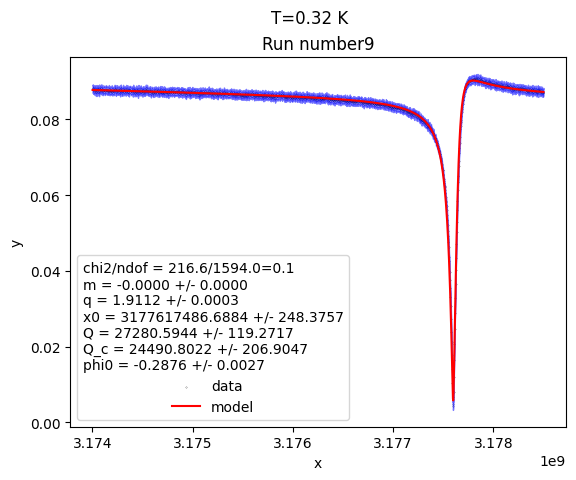

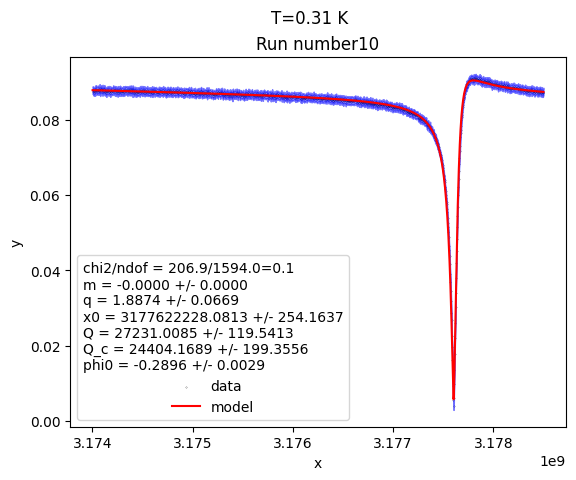

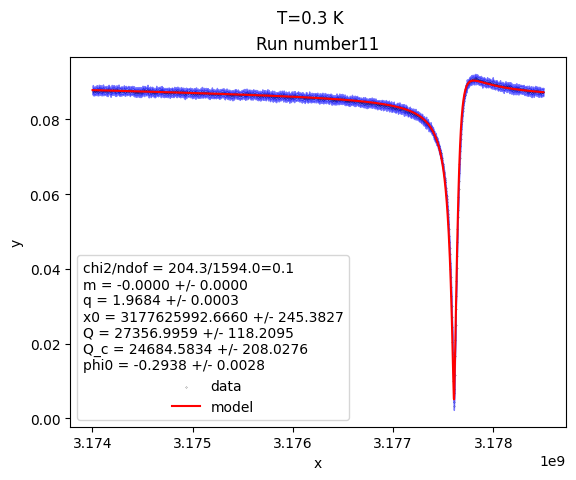

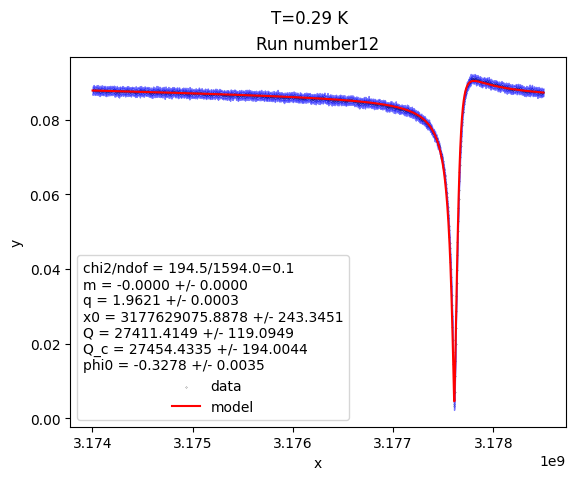

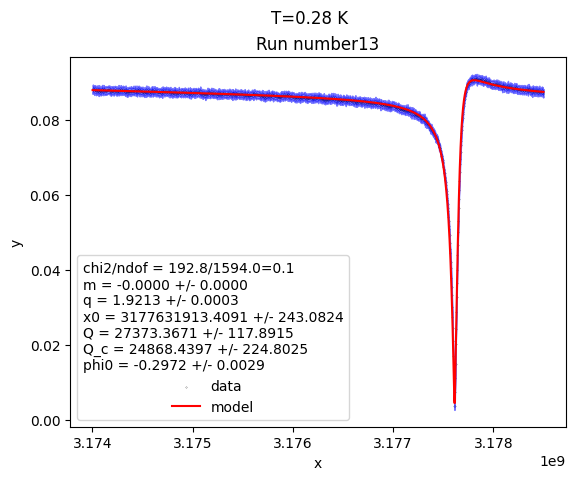

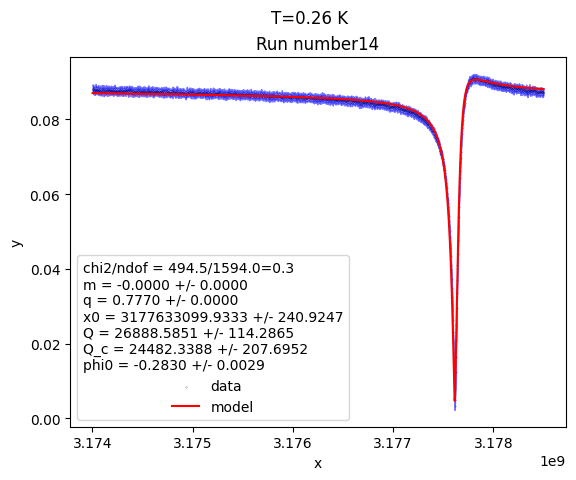

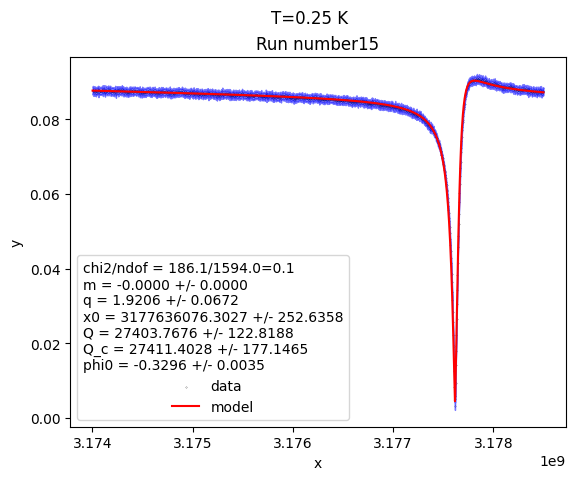

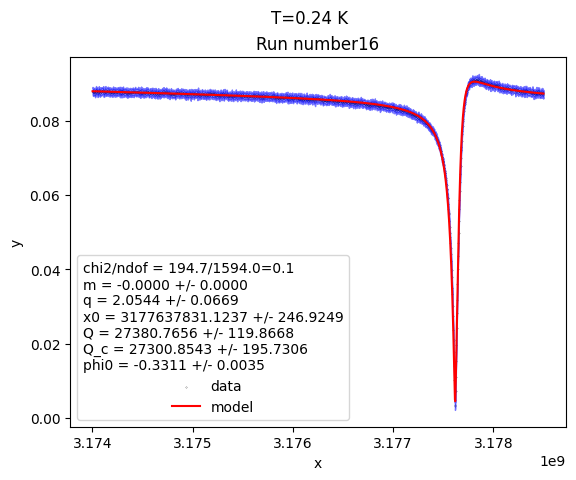

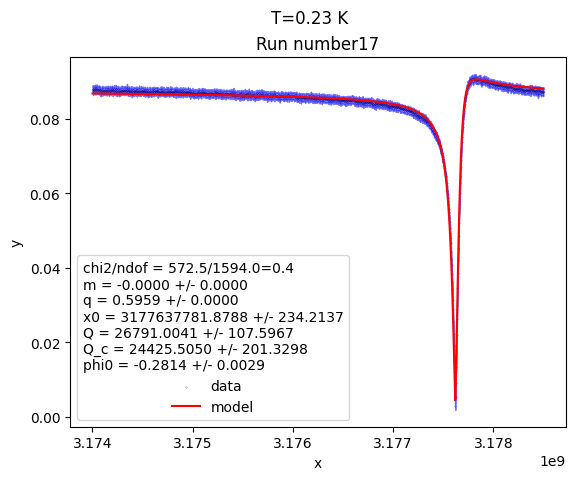

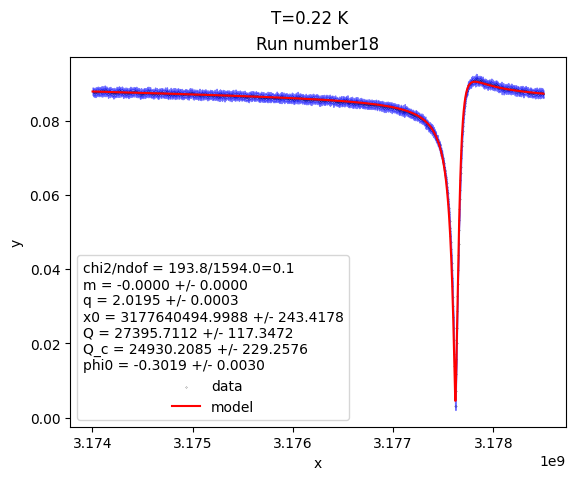

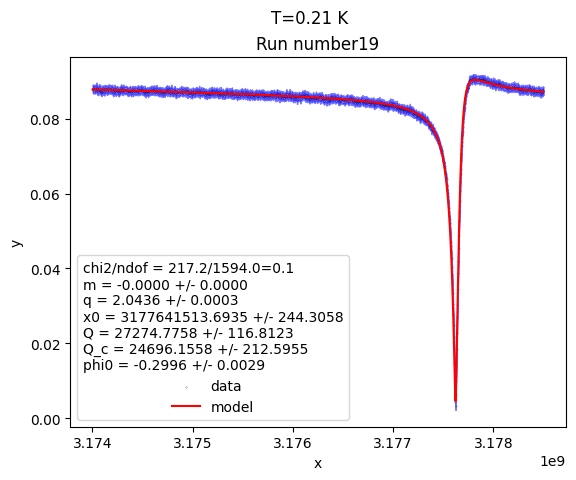

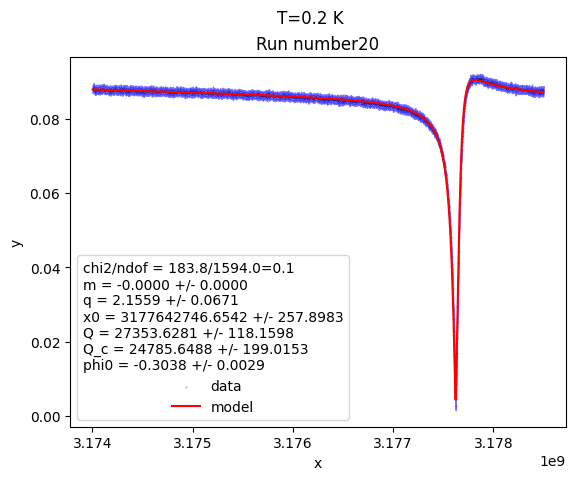

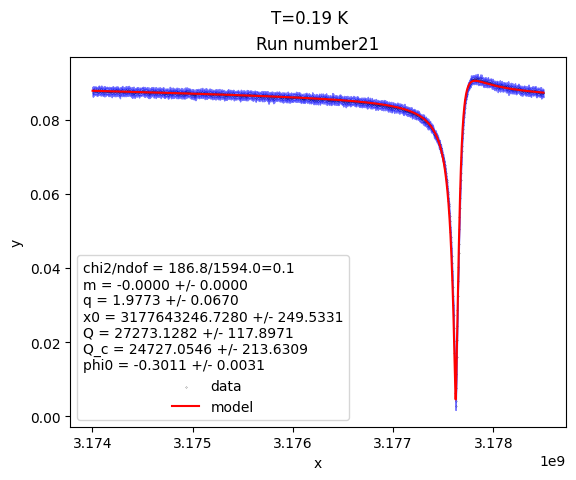

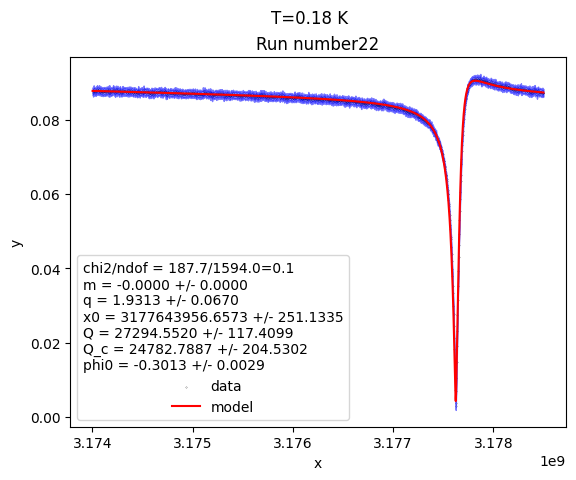

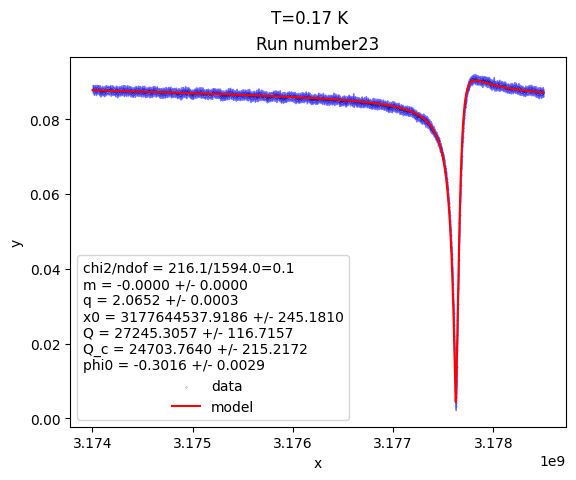

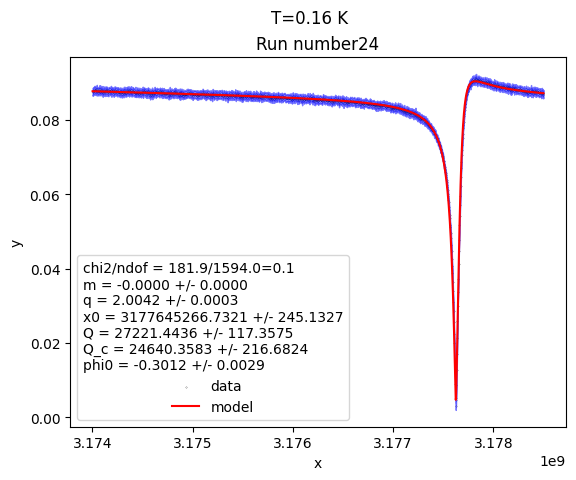

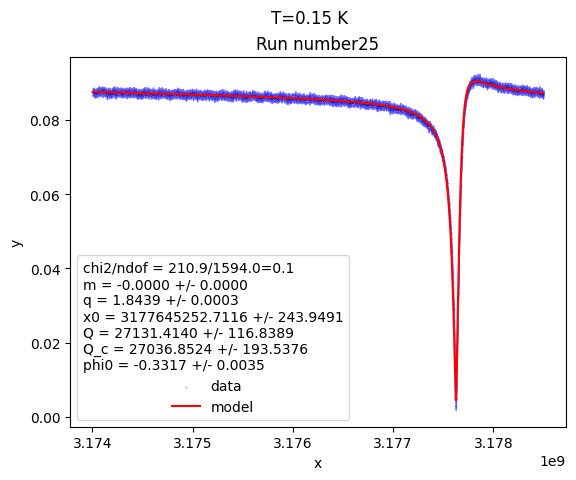

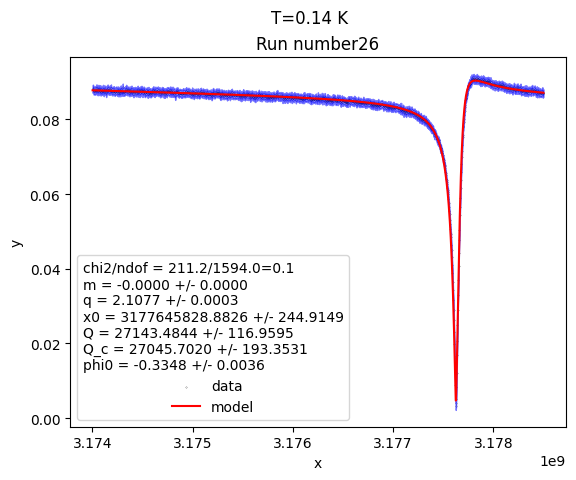

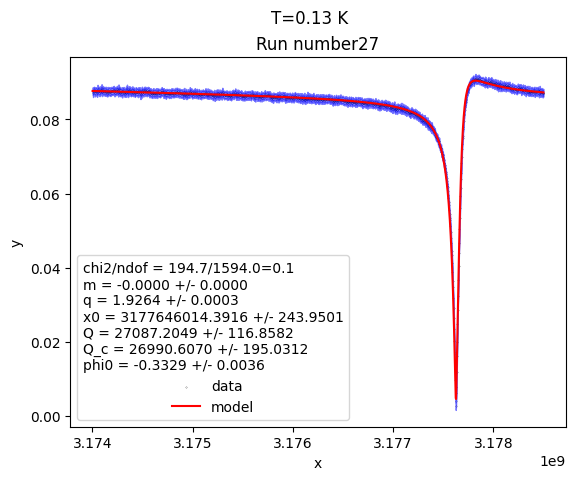

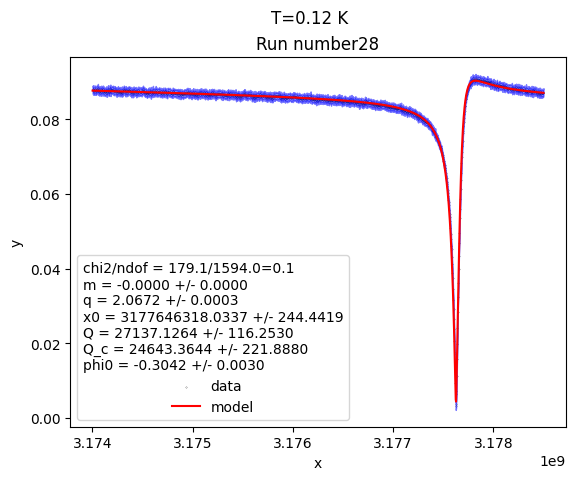

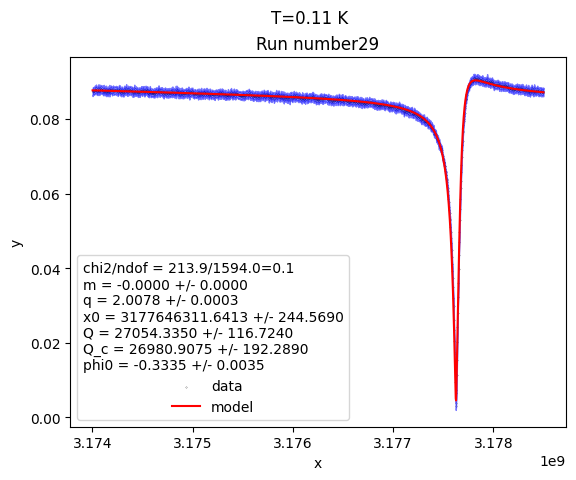

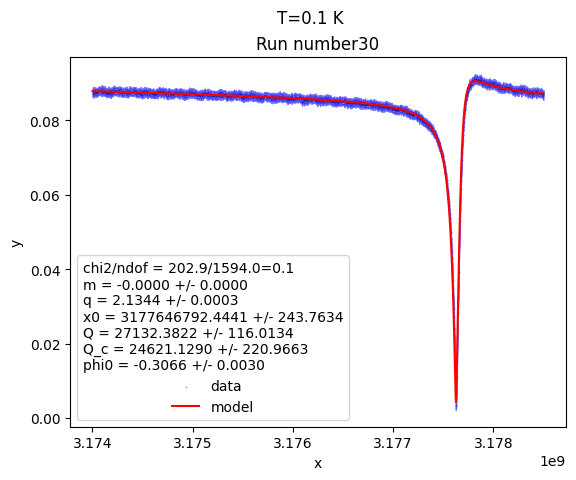

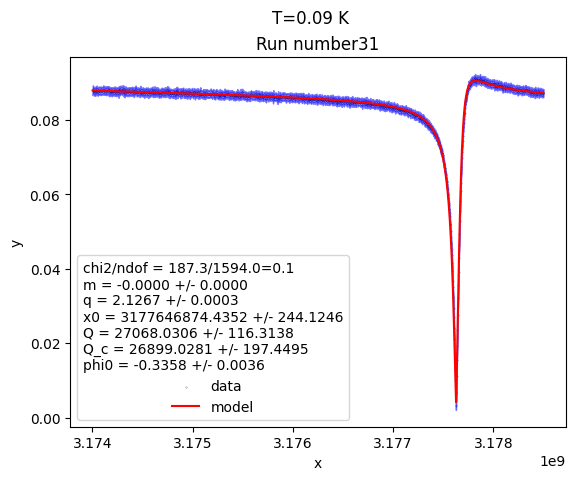

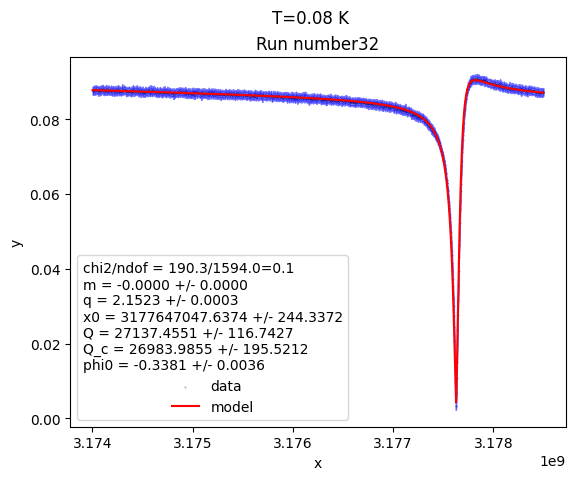

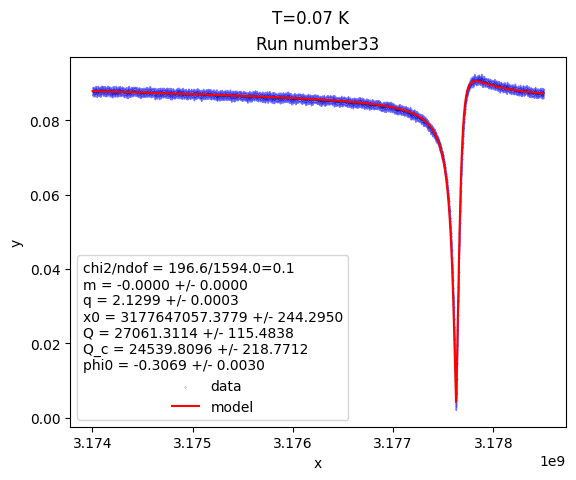

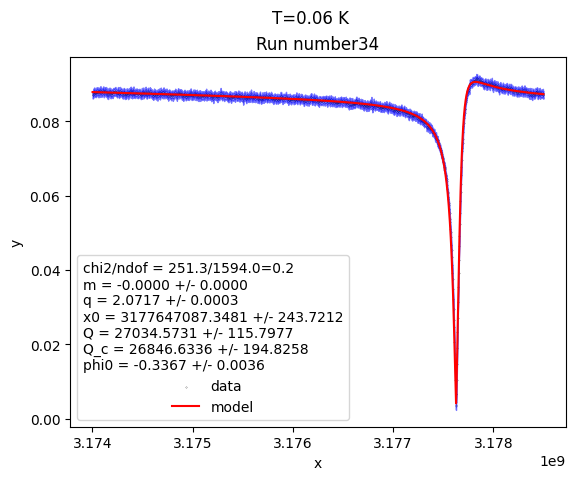

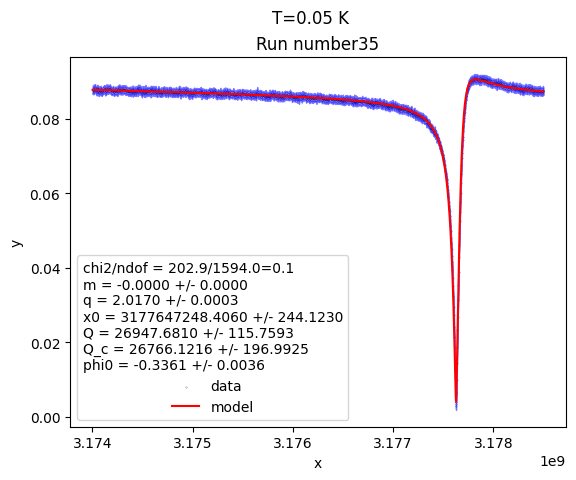

[<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1

In [8]:
plotter(m=m2, new_dfs=new_dfs2,t=new_temp2)

In [9]:
x,y = [], []
for i in range(len(m2)):
    y.append(m2[i].values[2]/1e9)
    x.append(new_temp2[i])
x = np.array(x)
y = np.array(y)

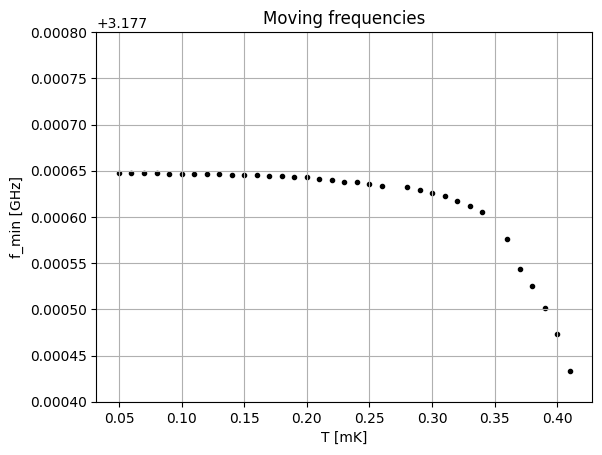

In [10]:
plt.scatter(x,y, marker='.',color='black')
plt.xlabel('T [mK]')
plt.ylabel('f_min [GHz]')
plt.ylim([3.1774,3.1778])
plt.title('Moving frequencies')
plt.grid()

Let's create a new file with $\frac{1}{Q}$, T and $\sigma_{T}$

In [16]:
Q_invs,Q_invs_err,Qs = [], [], []
for i in range(len(new_temp2)):
    Qs.append(m2[i].values['Q'])
    Q_invs.append(1/(m2[i].values['Q']))
    Q_invs_err.append(1/m2[i].values['Q']**2 * m2[i].errors['Q'])
Q_invs = np.array(Q_invs)
Q_invs_err = np.array(Q_invs_err)
new_temp2 = np.array(new_temp2)
datas = {'T':new_temp2,'1/Q':Q_invs,'1/Q_err':Q_invs_err}
dataframe = pd.DataFrame(data=datas)
dataframe.to_csv('Fitted.csv',sep='\t',index=False)